In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
from torch.utils.data import DataLoader
import numpy as np
import random
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
def set_seed(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
set_seed(0)

In [3]:
transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.5,], std=[0.5,])
])

trainset = tv.datasets.MNIST("MNIST/", train=True, transform=transform, download=True)
validset = tv.datasets.MNIST("MNIST/", train=False, transform=transform, download=True)
dataset = trainset + validset
train_loader = DataLoader(dataset, batch_size = 128, shuffle = True, num_workers = 0, pin_memory = True)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.D = nn.Sequential(
            # input is (1) x 28 x 28
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64) x 14 x 14
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (128) x 7 x 7
            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (256) x 4 x 4
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            # state size. (1) x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.D(x)

class Generator(nn.Module):
    def __init__(self, noize_dim):

        super(Generator, self).__init__()

        self.G = nn.Sequential(
            # input is (100) x 1 x 1
            nn.ConvTranspose2d( noize_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. (256) x 4 x 4
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. (128) x 8 x 8
            nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (64) x 16 x 16
            nn.ConvTranspose2d( 64, 1, 4, 2, 3, bias=False),
            # state size. (1) x 28 x 28
            nn.Tanh()
        )

    def forward(self, x):
        return self.G(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noize_dim = 100
G = Generator(noize_dim).to(device)
D = Discriminator().to(device)
criterion = nn.BCELoss()           # loss
G_optimizer = optim.Adam(G.parameters(), lr = 1e-3)   
D_optimizer = optim.Adam(D.parameters(), lr = 1e-3)

In [5]:
def D_train():
    D_optimizer.zero_grad()
    # 計算真實圖片的loss
    x_real = x.to(device)                                         
    y_real = torch.ones(x.size(0)).to(device)              #此時標籤為 1
    x_real_predict = D(x_real)                                     
    D_real_loss = criterion(x_real_predict.view(-1), y_real)      
    D_real_loss.backward()                                             

    # 計算假圖片的Loss：
    noise = torch.tensor(torch.randn(x.size(0), noize_dim, 1, 1)).to(device)    
    y_fake = torch.zeros(x.size(0)).to(device)             #此時標籤為 0         
    x_fake = G(noise)                                                                 
    x_fake_predict = D(x_fake)                                                        
    D_fake_loss = criterion(x_fake_predict.view(-1), y_fake)                    
    D_fake_loss.backward()                                                                

    # 計算鑑別器當前的總損失
    D_total_loss = D_real_loss + D_fake_loss        
    D_optimizer.step()                        

    return D_total_loss.item()    


def G_train():
    G_optimizer.zero_grad()

    # 訓練生成真實圖片
    noise = torch.tensor(torch.randn(x.size(0) ,noize_dim, 1 , 1)).to(device)
    y_target = torch.ones(x.size(0)).to(device)               # 這裡定義為 1               
    x_fake = G(noise)     
    y_fake = D(x_fake)     
    #計算損失
    G_loss = criterion(y_fake.view(-1), y_target) 
    G_loss.backward()
    G_optimizer.step()

    return G_loss.item()

        
def show_training_loss(loss_record):
    train_loss, valid_loss = [i for i in loss_record.values()]
    
    plt.plot(train_loss)
    plt.plot(valid_loss)
    #標題
    plt.title('Result')
    #y軸標籤
    plt.ylabel('Loss')
    #x軸標籤
    plt.xlabel('Epoch')
    #顯示折線的名稱
    plt.legend(['Discriminator', 'Generator'], loc='upper left')
    #顯示折線圖
    plt.show()

  0%|          | 0/469 [00:00<?, ?it/s]c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == "":
c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Train Epoch 0: 100%|██████████| 469/469 [00:28<00:00, 16.33it/s, D_loss=0.025, G_loss=7.244] 


Saving Model With Loss 8.73922
D_Loss: 0.04571 G_Loss: 8.73922| Best Loss: 8.73922



Train Epoch 1: 100%|██████████| 469/469 [00:27<00:00, 16.98it/s, D_loss=0.021, G_loss=9.198] 


Saving Model With Loss 8.66253
D_Loss: 0.05775 G_Loss: 8.66253| Best Loss: 8.66253



Train Epoch 2: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s, D_loss=0.012, G_loss=6.975] 


Saving Model With Loss 7.95361
D_Loss: 0.10188 G_Loss: 7.95361| Best Loss: 7.95361



Train Epoch 3: 100%|██████████| 469/469 [00:28<00:00, 16.66it/s, D_loss=0.064, G_loss=12.022]


Saving Model With Loss 7.16377
D_Loss: 0.11758 G_Loss: 7.16377| Best Loss: 7.16377



Train Epoch 4: 100%|██████████| 469/469 [00:27<00:00, 16.91it/s, D_loss=0.436, G_loss=2.649] 


D_Loss: 0.15214 G_Loss: 7.25998| Best Loss: 7.16377



Train Epoch 5: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s, D_loss=0.237, G_loss=3.606]


Saving Model With Loss 5.62433
D_Loss: 0.18694 G_Loss: 5.62433| Best Loss: 5.62433



Train Epoch 6: 100%|██████████| 469/469 [00:28<00:00, 16.26it/s, D_loss=0.105, G_loss=4.784] 


D_Loss: 0.23688 G_Loss: 5.65102| Best Loss: 5.62433



Train Epoch 7: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s, D_loss=1.163, G_loss=5.591] 


Saving Model With Loss 5.19396
D_Loss: 0.28157 G_Loss: 5.19396| Best Loss: 5.19396



Train Epoch 8: 100%|██████████| 469/469 [00:28<00:00, 16.74it/s, D_loss=0.237, G_loss=3.021] 


Saving Model With Loss 4.58586
D_Loss: 0.33078 G_Loss: 4.58586| Best Loss: 4.58586



Train Epoch 9: 100%|██████████| 469/469 [00:27<00:00, 16.96it/s, D_loss=0.330, G_loss=3.062]


Saving Model With Loss 4.07478
D_Loss: 0.29502 G_Loss: 4.07478| Best Loss: 4.07478



Train Epoch 10: 100%|██████████| 469/469 [00:27<00:00, 16.96it/s, D_loss=0.658, G_loss=1.010]


Saving Model With Loss 4.06737
D_Loss: 0.31811 G_Loss: 4.06737| Best Loss: 4.06737



Train Epoch 11: 100%|██████████| 469/469 [00:26<00:00, 17.46it/s, D_loss=0.287, G_loss=3.387]


Saving Model With Loss 3.89054
D_Loss: 0.33222 G_Loss: 3.89054| Best Loss: 3.89054



Train Epoch 12: 100%|██████████| 469/469 [00:27<00:00, 17.21it/s, D_loss=0.414, G_loss=5.216]


Saving Model With Loss 3.84024
D_Loss: 0.31792 G_Loss: 3.84024| Best Loss: 3.84024



Train Epoch 13: 100%|██████████| 469/469 [00:28<00:00, 16.49it/s, D_loss=0.422, G_loss=5.240]


Saving Model With Loss 3.81301
D_Loss: 0.41887 G_Loss: 3.81301| Best Loss: 3.81301



Train Epoch 14: 100%|██████████| 469/469 [00:27<00:00, 17.23it/s, D_loss=0.490, G_loss=1.825]


Saving Model With Loss 3.51982
D_Loss: 0.40112 G_Loss: 3.51982| Best Loss: 3.51982



Train Epoch 15: 100%|██████████| 469/469 [00:26<00:00, 17.50it/s, D_loss=0.852, G_loss=3.393]


Saving Model With Loss 3.38356
D_Loss: 0.39237 G_Loss: 3.38356| Best Loss: 3.38356



Train Epoch 16: 100%|██████████| 469/469 [00:26<00:00, 17.64it/s, D_loss=0.322, G_loss=1.877]


D_Loss: 0.46249 G_Loss: 3.40692| Best Loss: 3.38356



Train Epoch 17: 100%|██████████| 469/469 [00:27<00:00, 17.00it/s, D_loss=0.331, G_loss=2.736]


Saving Model With Loss 3.18880
D_Loss: 0.42807 G_Loss: 3.18880| Best Loss: 3.18880



Train Epoch 18: 100%|██████████| 469/469 [00:27<00:00, 17.21it/s, D_loss=0.334, G_loss=2.764]


Saving Model With Loss 3.13544
D_Loss: 0.43772 G_Loss: 3.13544| Best Loss: 3.13544



Train Epoch 19: 100%|██████████| 469/469 [00:26<00:00, 17.63it/s, D_loss=0.291, G_loss=2.427]


Saving Model With Loss 3.10467
D_Loss: 0.45528 G_Loss: 3.10467| Best Loss: 3.10467



Train Epoch 20: 100%|██████████| 469/469 [00:27<00:00, 17.31it/s, D_loss=0.931, G_loss=2.168]


D_Loss: 0.40354 G_Loss: 3.20937| Best Loss: 3.10467



Train Epoch 21: 100%|██████████| 469/469 [00:27<00:00, 16.98it/s, D_loss=0.164, G_loss=0.600]


D_Loss: 0.44460 G_Loss: 3.11690| Best Loss: 3.10467



Train Epoch 22: 100%|██████████| 469/469 [00:28<00:00, 16.32it/s, D_loss=0.634, G_loss=3.785]


Saving Model With Loss 3.10259
D_Loss: 0.46256 G_Loss: 3.10259| Best Loss: 3.10259



Train Epoch 23: 100%|██████████| 469/469 [00:27<00:00, 17.03it/s, D_loss=0.464, G_loss=1.893]


D_Loss: 0.47487 G_Loss: 3.11905| Best Loss: 3.10259



Train Epoch 24: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s, D_loss=0.231, G_loss=3.034]


Saving Model With Loss 3.00002
D_Loss: 0.47134 G_Loss: 3.00002| Best Loss: 3.00002



Train Epoch 25: 100%|██████████| 469/469 [00:27<00:00, 17.15it/s, D_loss=0.206, G_loss=1.963]


D_Loss: 0.48761 G_Loss: 3.10607| Best Loss: 3.00002



Train Epoch 26: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s, D_loss=0.531, G_loss=1.482]


Saving Model With Loss 2.92682
D_Loss: 0.43517 G_Loss: 2.92682| Best Loss: 2.92682



Train Epoch 27: 100%|██████████| 469/469 [00:27<00:00, 17.08it/s, D_loss=0.317, G_loss=2.814]


D_Loss: 0.49740 G_Loss: 3.10704| Best Loss: 2.92682



Train Epoch 28: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s, D_loss=0.264, G_loss=2.823]


D_Loss: 0.45813 G_Loss: 3.06268| Best Loss: 2.92682



Train Epoch 29: 100%|██████████| 469/469 [00:26<00:00, 17.45it/s, D_loss=0.391, G_loss=2.989]


D_Loss: 0.42252 G_Loss: 3.07467| Best Loss: 2.92682



Train Epoch 30: 100%|██████████| 469/469 [00:29<00:00, 16.10it/s, D_loss=0.657, G_loss=3.717]


D_Loss: 0.44079 G_Loss: 3.12776| Best Loss: 2.92682



Train Epoch 31: 100%|██████████| 469/469 [00:27<00:00, 17.04it/s, D_loss=0.642, G_loss=2.630]


D_Loss: 0.41360 G_Loss: 3.12707| Best Loss: 2.92682



Train Epoch 32: 100%|██████████| 469/469 [00:27<00:00, 17.25it/s, D_loss=0.368, G_loss=0.958]


D_Loss: 0.43363 G_Loss: 3.03356| Best Loss: 2.92682



Train Epoch 33: 100%|██████████| 469/469 [00:26<00:00, 17.56it/s, D_loss=0.496, G_loss=2.841]


D_Loss: 0.40279 G_Loss: 3.22926| Best Loss: 2.92682



Train Epoch 34: 100%|██████████| 469/469 [00:27<00:00, 17.37it/s, D_loss=0.734, G_loss=3.849]


D_Loss: 0.33050 G_Loss: 3.27773| Best Loss: 2.92682



Train Epoch 35: 100%|██████████| 469/469 [00:27<00:00, 17.24it/s, D_loss=0.165, G_loss=4.627]


D_Loss: 0.38638 G_Loss: 3.32817| Best Loss: 2.92682



Train Epoch 36: 100%|██████████| 469/469 [00:27<00:00, 17.03it/s, D_loss=0.783, G_loss=2.669]


D_Loss: 0.38844 G_Loss: 3.26559| Best Loss: 2.92682



Train Epoch 37: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s, D_loss=0.410, G_loss=2.805]


D_Loss: 0.41965 G_Loss: 3.29794| Best Loss: 2.92682



Train Epoch 38: 100%|██████████| 469/469 [00:27<00:00, 17.33it/s, D_loss=0.781, G_loss=5.210]


D_Loss: 0.34950 G_Loss: 3.27730| Best Loss: 2.92682



Train Epoch 39: 100%|██████████| 469/469 [00:28<00:00, 16.71it/s, D_loss=0.468, G_loss=5.269]


D_Loss: 0.35690 G_Loss: 3.39335| Best Loss: 2.92682



Train Epoch 40: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s, D_loss=0.356, G_loss=1.403]


D_Loss: 0.32927 G_Loss: 3.38239| Best Loss: 2.92682



Train Epoch 41: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s, D_loss=0.343, G_loss=4.620]


D_Loss: 0.35742 G_Loss: 3.50268| Best Loss: 2.92682



Train Epoch 42: 100%|██████████| 469/469 [00:27<00:00, 16.98it/s, D_loss=0.249, G_loss=1.767]


D_Loss: 0.31080 G_Loss: 3.44395| Best Loss: 2.92682



Train Epoch 43: 100%|██████████| 469/469 [00:27<00:00, 16.88it/s, D_loss=1.375, G_loss=3.806]


D_Loss: 0.36551 G_Loss: 3.49998| Best Loss: 2.92682



Train Epoch 44: 100%|██████████| 469/469 [00:28<00:00, 16.46it/s, D_loss=0.147, G_loss=7.660]


D_Loss: 0.40717 G_Loss: 3.37549| Best Loss: 2.92682



Train Epoch 45: 100%|██████████| 469/469 [00:28<00:00, 16.70it/s, D_loss=0.104, G_loss=4.911]


D_Loss: 0.34298 G_Loss: 3.59601| Best Loss: 2.92682



Train Epoch 46: 100%|██████████| 469/469 [00:27<00:00, 17.28it/s, D_loss=0.434, G_loss=2.973]


D_Loss: 0.31257 G_Loss: 3.49790| Best Loss: 2.92682



Train Epoch 47: 100%|██████████| 469/469 [00:27<00:00, 16.81it/s, D_loss=0.289, G_loss=1.964]


D_Loss: 0.34585 G_Loss: 3.59791| Best Loss: 2.92682



Train Epoch 48: 100%|██████████| 469/469 [00:27<00:00, 17.33it/s, D_loss=0.325, G_loss=4.802]


D_Loss: 0.37922 G_Loss: 3.56988| Best Loss: 2.92682



Train Epoch 49: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s, D_loss=0.173, G_loss=4.889]


D_Loss: 0.31615 G_Loss: 3.53042| Best Loss: 2.92682



Train Epoch 50: 100%|██████████| 469/469 [00:27<00:00, 16.78it/s, D_loss=0.345, G_loss=1.501]


D_Loss: 0.36171 G_Loss: 3.63955| Best Loss: 2.92682



Train Epoch 51: 100%|██████████| 469/469 [00:27<00:00, 16.97it/s, D_loss=0.953, G_loss=3.449]


D_Loss: 0.32907 G_Loss: 3.58625| Best Loss: 2.92682



Train Epoch 52: 100%|██████████| 469/469 [00:28<00:00, 16.35it/s, D_loss=0.152, G_loss=3.767]


D_Loss: 0.26001 G_Loss: 3.67441| Best Loss: 2.92682



Train Epoch 53: 100%|██████████| 469/469 [00:28<00:00, 16.34it/s, D_loss=2.176, G_loss=4.447]


D_Loss: 0.25333 G_Loss: 3.72575| Best Loss: 2.92682



Train Epoch 54: 100%|██████████| 469/469 [00:27<00:00, 17.07it/s, D_loss=0.291, G_loss=4.844]


D_Loss: 0.39529 G_Loss: 3.61334| Best Loss: 2.92682



Train Epoch 55: 100%|██████████| 469/469 [00:27<00:00, 16.99it/s, D_loss=0.247, G_loss=4.038]


D_Loss: 0.25070 G_Loss: 3.74205| Best Loss: 2.92682



Train Epoch 56: 100%|██████████| 469/469 [00:29<00:00, 15.69it/s, D_loss=0.119, G_loss=3.175]


D_Loss: 0.35170 G_Loss: 3.77165| Best Loss: 2.92682



Train Epoch 57: 100%|██████████| 469/469 [00:27<00:00, 17.12it/s, D_loss=0.130, G_loss=5.900]


D_Loss: 0.34820 G_Loss: 3.68758| Best Loss: 2.92682



Train Epoch 58: 100%|██████████| 469/469 [00:27<00:00, 16.94it/s, D_loss=0.541, G_loss=1.651]


D_Loss: 0.26003 G_Loss: 3.76674| Best Loss: 2.92682



Train Epoch 59: 100%|██████████| 469/469 [00:27<00:00, 16.76it/s, D_loss=0.229, G_loss=4.848]


D_Loss: 0.35952 G_Loss: 3.81184| Best Loss: 2.92682



Train Epoch 60: 100%|██████████| 469/469 [00:29<00:00, 15.76it/s, D_loss=0.317, G_loss=2.174]


D_Loss: 0.31710 G_Loss: 3.70326| Best Loss: 2.92682



Train Epoch 61: 100%|██████████| 469/469 [00:27<00:00, 17.15it/s, D_loss=0.266, G_loss=4.676]


D_Loss: 0.26326 G_Loss: 3.72938| Best Loss: 2.92682



Train Epoch 62: 100%|██████████| 469/469 [00:28<00:00, 16.73it/s, D_loss=0.103, G_loss=4.185]


D_Loss: 0.23293 G_Loss: 3.88130| Best Loss: 2.92682



Train Epoch 63: 100%|██████████| 469/469 [00:27<00:00, 16.88it/s, D_loss=0.413, G_loss=2.003]


D_Loss: 0.28454 G_Loss: 3.92895| Best Loss: 2.92682



Train Epoch 64: 100%|██████████| 469/469 [00:28<00:00, 16.43it/s, D_loss=0.209, G_loss=4.700]


D_Loss: 0.28486 G_Loss: 3.77968| Best Loss: 2.92682



Train Epoch 65: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s, D_loss=0.271, G_loss=5.192]


D_Loss: 0.30266 G_Loss: 3.91786| Best Loss: 2.92682



Train Epoch 66: 100%|██████████| 469/469 [00:28<00:00, 16.51it/s, D_loss=0.263, G_loss=3.657]


D_Loss: 0.23445 G_Loss: 3.85458| Best Loss: 2.92682



Train Epoch 67: 100%|██████████| 469/469 [00:27<00:00, 16.92it/s, D_loss=0.247, G_loss=2.784]


D_Loss: 0.28911 G_Loss: 4.07264| Best Loss: 2.92682



Train Epoch 68: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s, D_loss=0.075, G_loss=2.598]


D_Loss: 0.23335 G_Loss: 3.90602| Best Loss: 2.92682



Train Epoch 69: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s, D_loss=0.156, G_loss=4.234]


D_Loss: 0.21831 G_Loss: 4.04951| Best Loss: 2.92682



Train Epoch 70: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s, D_loss=0.312, G_loss=5.324]


D_Loss: 0.30015 G_Loss: 4.08593| Best Loss: 2.92682



Train Epoch 71: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s, D_loss=0.244, G_loss=2.901]


D_Loss: 0.24682 G_Loss: 3.99217| Best Loss: 2.92682



Train Epoch 72: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s, D_loss=0.635, G_loss=3.919]


D_Loss: 0.23403 G_Loss: 4.15134| Best Loss: 2.92682



Train Epoch 73: 100%|██████████| 469/469 [00:29<00:00, 15.93it/s, D_loss=0.316, G_loss=3.468]


D_Loss: 0.27168 G_Loss: 4.07324| Best Loss: 2.92682



Train Epoch 74: 100%|██████████| 469/469 [00:27<00:00, 17.04it/s, D_loss=0.321, G_loss=4.206] 


D_Loss: 0.19983 G_Loss: 4.21060| Best Loss: 2.92682



Train Epoch 75: 100%|██████████| 469/469 [00:27<00:00, 17.01it/s, D_loss=0.643, G_loss=4.679]


D_Loss: 0.31994 G_Loss: 4.13692| Best Loss: 2.92682



Train Epoch 76: 100%|██████████| 469/469 [00:27<00:00, 17.07it/s, D_loss=0.118, G_loss=2.830]


D_Loss: 0.18453 G_Loss: 4.18365| Best Loss: 2.92682



Train Epoch 77: 100%|██████████| 469/469 [00:28<00:00, 16.65it/s, D_loss=0.222, G_loss=5.699]


D_Loss: 0.15967 G_Loss: 4.29618| Best Loss: 2.92682



Train Epoch 78: 100%|██████████| 469/469 [00:27<00:00, 17.00it/s, D_loss=0.068, G_loss=6.540] 


D_Loss: 0.30372 G_Loss: 4.43019| Best Loss: 2.92682



Train Epoch 79: 100%|██████████| 469/469 [00:28<00:00, 16.63it/s, D_loss=0.285, G_loss=3.789]


D_Loss: 0.25361 G_Loss: 4.18858| Best Loss: 2.92682



Train Epoch 80: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s, D_loss=0.163, G_loss=5.909]


D_Loss: 0.19502 G_Loss: 4.32716| Best Loss: 2.92682



Train Epoch 81: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s, D_loss=0.251, G_loss=4.859]


D_Loss: 0.22121 G_Loss: 4.27053| Best Loss: 2.92682



Train Epoch 82: 100%|██████████| 469/469 [00:27<00:00, 16.98it/s, D_loss=0.133, G_loss=1.974] 


D_Loss: 0.20163 G_Loss: 4.45014| Best Loss: 2.92682



Train Epoch 83: 100%|██████████| 469/469 [00:27<00:00, 17.01it/s, D_loss=0.284, G_loss=1.904]


D_Loss: 0.25890 G_Loss: 4.25022| Best Loss: 2.92682



Train Epoch 84: 100%|██████████| 469/469 [00:27<00:00, 17.23it/s, D_loss=0.048, G_loss=4.662]


D_Loss: 0.15590 G_Loss: 4.44470| Best Loss: 2.92682



Train Epoch 85: 100%|██████████| 469/469 [00:28<00:00, 16.43it/s, D_loss=0.153, G_loss=3.404] 


D_Loss: 0.20884 G_Loss: 4.53094| Best Loss: 2.92682



Train Epoch 86: 100%|██████████| 469/469 [00:27<00:00, 16.93it/s, D_loss=0.102, G_loss=4.506] 


D_Loss: 0.30391 G_Loss: 4.40050| Best Loss: 2.92682



Train Epoch 87: 100%|██████████| 469/469 [00:27<00:00, 16.92it/s, D_loss=0.070, G_loss=5.397]


D_Loss: 0.17658 G_Loss: 4.26827| Best Loss: 2.92682



Train Epoch 88: 100%|██████████| 469/469 [00:28<00:00, 16.66it/s, D_loss=0.148, G_loss=4.638] 


D_Loss: 0.19873 G_Loss: 4.57916| Best Loss: 2.92682



Train Epoch 89: 100%|██████████| 469/469 [00:27<00:00, 17.21it/s, D_loss=0.067, G_loss=5.304]


D_Loss: 0.11720 G_Loss: 4.61378| Best Loss: 2.92682



Train Epoch 90: 100%|██████████| 469/469 [00:27<00:00, 16.93it/s, D_loss=0.051, G_loss=3.602] 


D_Loss: 0.25894 G_Loss: 4.59333| Best Loss: 2.92682



Train Epoch 91: 100%|██████████| 469/469 [00:27<00:00, 16.96it/s, D_loss=0.752, G_loss=4.822] 


D_Loss: 0.24748 G_Loss: 4.39738| Best Loss: 2.92682



Train Epoch 92: 100%|██████████| 469/469 [00:27<00:00, 16.96it/s, D_loss=0.318, G_loss=8.483] 


D_Loss: 0.21028 G_Loss: 4.50381| Best Loss: 2.92682



Train Epoch 93: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s, D_loss=0.124, G_loss=2.739]


D_Loss: 0.13685 G_Loss: 4.70233| Best Loss: 2.92682



Train Epoch 94: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s, D_loss=0.206, G_loss=2.558] 


D_Loss: 0.26994 G_Loss: 4.74363| Best Loss: 2.92682



Train Epoch 95: 100%|██████████| 469/469 [00:27<00:00, 17.02it/s, D_loss=0.088, G_loss=7.575]


D_Loss: 0.12002 G_Loss: 4.46845| Best Loss: 2.92682



Train Epoch 96: 100%|██████████| 469/469 [00:27<00:00, 17.16it/s, D_loss=0.095, G_loss=7.033] 


D_Loss: 0.18475 G_Loss: 4.82513| Best Loss: 2.92682



Train Epoch 97: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s, D_loss=0.152, G_loss=2.709] 


D_Loss: 0.21232 G_Loss: 4.71694| Best Loss: 2.92682



Train Epoch 98: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s, D_loss=0.186, G_loss=2.543] 


D_Loss: 0.18735 G_Loss: 4.69737| Best Loss: 2.92682



Train Epoch 99: 100%|██████████| 469/469 [00:27<00:00, 16.89it/s, D_loss=0.229, G_loss=7.048] 


D_Loss: 0.23849 G_Loss: 4.73761| Best Loss: 2.92682



Train Epoch 100: 100%|██████████| 469/469 [00:28<00:00, 16.20it/s, D_loss=0.030, G_loss=4.525] 


D_Loss: 0.14185 G_Loss: 4.64024| Best Loss: 2.92682



Train Epoch 101: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s, D_loss=0.066, G_loss=5.145] 


D_Loss: 0.20260 G_Loss: 4.83773| Best Loss: 2.92682



Train Epoch 102: 100%|██████████| 469/469 [00:28<00:00, 16.55it/s, D_loss=0.046, G_loss=6.379] 


D_Loss: 0.18794 G_Loss: 4.56178| Best Loss: 2.92682



Train Epoch 103: 100%|██████████| 469/469 [00:28<00:00, 16.52it/s, D_loss=0.114, G_loss=6.454]


D_Loss: 0.12463 G_Loss: 4.78096| Best Loss: 2.92682



Train Epoch 104: 100%|██████████| 469/469 [00:27<00:00, 17.24it/s, D_loss=0.108, G_loss=3.222] 


D_Loss: 0.19467 G_Loss: 4.80617| Best Loss: 2.92682



Train Epoch 105: 100%|██████████| 469/469 [00:27<00:00, 17.35it/s, D_loss=0.092, G_loss=3.493]


D_Loss: 0.10179 G_Loss: 4.79401| Best Loss: 2.92682



Train Epoch 106: 100%|██████████| 469/469 [00:28<00:00, 16.45it/s, D_loss=1.700, G_loss=10.587]


D_Loss: 0.33628 G_Loss: 5.29449| Best Loss: 2.92682



Train Epoch 107: 100%|██████████| 469/469 [00:27<00:00, 17.25it/s, D_loss=0.066, G_loss=3.745]


D_Loss: 0.25445 G_Loss: 4.26214| Best Loss: 2.92682



Train Epoch 108: 100%|██████████| 469/469 [00:28<00:00, 16.44it/s, D_loss=0.089, G_loss=4.003]


D_Loss: 0.09342 G_Loss: 4.73388| Best Loss: 2.92682



Train Epoch 109: 100%|██████████| 469/469 [00:27<00:00, 16.84it/s, D_loss=0.032, G_loss=5.080] 


D_Loss: 0.10667 G_Loss: 5.11408| Best Loss: 2.92682



Train Epoch 110: 100%|██████████| 469/469 [00:27<00:00, 17.11it/s, D_loss=0.044, G_loss=6.265] 


D_Loss: 0.10227 G_Loss: 5.04662| Best Loss: 2.92682



Train Epoch 111: 100%|██████████| 469/469 [00:26<00:00, 17.54it/s, D_loss=0.190, G_loss=1.488] 


D_Loss: 0.19085 G_Loss: 5.07656| Best Loss: 2.92682



Train Epoch 112: 100%|██████████| 469/469 [00:27<00:00, 17.10it/s, D_loss=0.059, G_loss=0.782] 


D_Loss: 0.29912 G_Loss: 4.51716| Best Loss: 2.92682



Train Epoch 113: 100%|██████████| 469/469 [00:27<00:00, 17.16it/s, D_loss=0.361, G_loss=5.700]


D_Loss: 0.15245 G_Loss: 4.69729| Best Loss: 2.92682



Train Epoch 114: 100%|██████████| 469/469 [00:27<00:00, 17.35it/s, D_loss=0.088, G_loss=4.674]


D_Loss: 0.07518 G_Loss: 5.05419| Best Loss: 2.92682



Train Epoch 115: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s, D_loss=0.069, G_loss=1.106] 


D_Loss: 0.16523 G_Loss: 5.22698| Best Loss: 2.92682



Train Epoch 116: 100%|██████████| 469/469 [00:27<00:00, 17.04it/s, D_loss=0.066, G_loss=3.505] 


D_Loss: 0.29772 G_Loss: 4.68847| Best Loss: 2.92682



Train Epoch 117: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s, D_loss=0.024, G_loss=5.633] 


D_Loss: 0.11601 G_Loss: 4.93673| Best Loss: 2.92682



Train Epoch 118: 100%|██████████| 469/469 [00:27<00:00, 17.24it/s, D_loss=0.603, G_loss=3.634] 


D_Loss: 0.12541 G_Loss: 5.07062| Best Loss: 2.92682



Train Epoch 119: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s, D_loss=0.264, G_loss=4.945] 


D_Loss: 0.12134 G_Loss: 4.97053| Best Loss: 2.92682



Train Epoch 120: 100%|██████████| 469/469 [00:27<00:00, 17.23it/s, D_loss=1.482, G_loss=1.830] 


D_Loss: 0.18463 G_Loss: 5.12356| Best Loss: 2.92682



Train Epoch 121: 100%|██████████| 469/469 [00:27<00:00, 17.29it/s, D_loss=0.218, G_loss=5.429] 


D_Loss: 0.17423 G_Loss: 4.91248| Best Loss: 2.92682



Train Epoch 122: 100%|██████████| 469/469 [00:27<00:00, 16.94it/s, D_loss=0.428, G_loss=5.695] 


D_Loss: 0.12870 G_Loss: 5.18492| Best Loss: 2.92682



Train Epoch 123: 100%|██████████| 469/469 [00:27<00:00, 16.95it/s, D_loss=0.080, G_loss=8.888] 


D_Loss: 0.15817 G_Loss: 5.02955| Best Loss: 2.92682



Train Epoch 124: 100%|██████████| 469/469 [00:27<00:00, 16.91it/s, D_loss=0.174, G_loss=8.847] 


D_Loss: 0.07977 G_Loss: 5.36239| Best Loss: 2.92682



Train Epoch 125: 100%|██████████| 469/469 [00:27<00:00, 17.00it/s, D_loss=0.055, G_loss=6.371] 


D_Loss: 0.11961 G_Loss: 5.35293| Best Loss: 2.92682



Train Epoch 126: 100%|██████████| 469/469 [00:26<00:00, 17.57it/s, D_loss=0.480, G_loss=1.780] 


------------------------------------
|Model can't improve, stop training|
------------------------------------


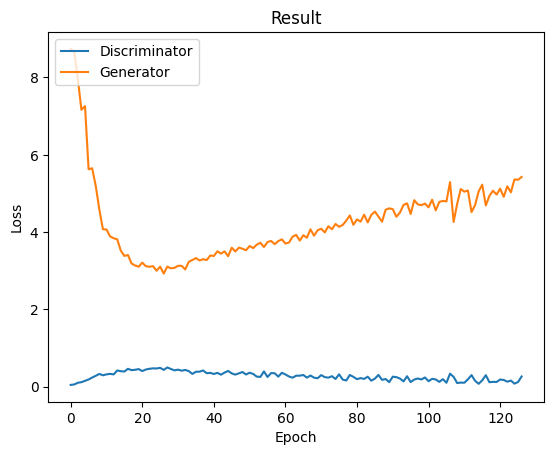

In [6]:
epochs = 1000                              # 訓練次數
early_stopping = 100                      # 模型訓練幾次沒進步就停止
stop_cnt = 0                             # 計數模型是否有進步的計數器
show_loss = True                         # 是否顯示訓練折線圖
best_loss = float('inf')                             # 最佳的準確率
loss_record = {'Discriminator':[], 'Generator':[]}   # 訓練紀錄


for epoch in range(epochs):    
    train_pbar = tqdm(train_loader, position=0, leave=True) # 宣告進度條
    D_record, G_record = [], []
    for idx, (x, _) in enumerate(train_pbar):
        D_loss = D_train()
        G_loss = G_train()

        D_record.append(D_loss)
        G_record.append(G_loss)
        
        train_pbar.set_description(f'Train Epoch {epoch}')  # 顯示訓練次數
        train_pbar.set_postfix({'D_loss':f'{D_loss:.3f}', 'G_loss':f'{G_loss:.3f}'}) # 顯示當下模型損失
    
    D_loss = sum(D_record)/len(D_record)
    G_loss = sum(G_record)/len(G_record)

    loss_record['Discriminator'].append(D_loss)
    loss_record['Generator'].append(G_loss)

    if G_loss < best_loss:
        best_loss = G_loss
        torch.save(D.state_dict(), 'D_model.ckpt')
        torch.save(G.state_dict(), 'G_model.ckpt')
        print(f'Saving Model With Loss {best_loss:.5f}')
        stop_cnt = 0
    else:
        stop_cnt+=1



    # Early stopping
    if stop_cnt == early_stopping:
        output = "Model can't improve, stop training"
        print('-' * (len(output)+2))
        print(f'|{output}|')
        print('-' * (len(output)+2))
        break
        
    print(f'D_Loss: {D_loss:.5f} G_Loss: {G_loss:.5f}', end='| ')
    print(f'Best Loss: {best_loss:.5f}', end ='\n\n')

if show_loss:
    show_training_loss(loss_record)

In [6]:
G = Generator(noize_dim)
G.load_state_dict(torch.load('G_model.ckpt'))
G.eval().to(device)

Generator(
  (G): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (10): Tanh()
  )
)

c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


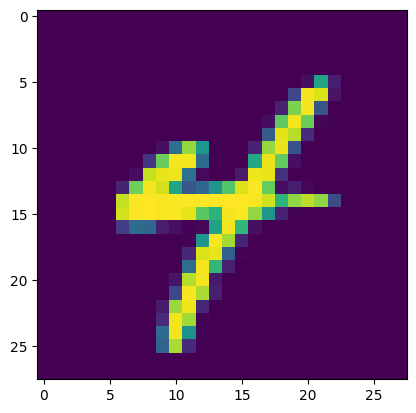

In [13]:
import cv2
noize = torch.tensor(torch.randn(70000, noize_dim, 1, 1)).to(device) 
fake = G(noize)
fake = np.array(fake.detach().cpu())
for cnt, img in enumerate(fake):
    npimg = (img/2+0.5)*255        
    npimg = np.transpose(npimg, (1, 2, 0))      
    #cv2.imwrite(f'fake_image/fake_{cnt}.png', npimg.astype('uint8'))
plt.imshow(npimg)                            